In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import ctypes
import importlib

import ephem_forces

Here we demonstrate the ASSIST ephemeris-quality integrator by calling a python-wrapped C function that has been compiled into a library.  That library is imported with the ephem_forces.py package.

The primary function in ephem_forces is 'integration_function', although we will access it with a higher-level function called 'production_integration_function_wrapper'.  

'integration_function' integrates massless test particles in the field of the Sun, planets, moon, and 16 massive asteroids.  It also includes the J2 and J4 gravitational harmonics of the Earth, the J2 gravitational harmonic of the Sun, and the solar GR terms (using the PPN formulation).  

The positions of the massive bodies come from two binary files, both from JPL.  The first is for the Sun, planets, and moon, with the latest DE441 ephemeris. The other is for the asteroids, corresponding to DE441.  

The coordinate frame and units are not flexible, currently.  The coordinate frame is the equatorial ICRF, which is the native coordinate system for the JPL binary files.  Note that this is equatorial rather than ecliptic.  In addition, the native coordinates are barycentric, rather than heliocentric. 

For units we use solar masses, au, and days.  The independent time coordinate is TDB in Julian days.

In [2]:
# This is the one being compared to Davide's stuff.
# DE441 
# heliocentric
#2458849.500000000 = A.D. 2020-Jan-01 00:00:00.0000 TDB [del_T=     69.183900 s]
# X = 3.342674681639715E+00 Y =-9.244683523355280E-01 Z =-5.068395961023143E-01
# VX= 2.814015548668069E-03 VY= 7.552327120972679E-03 VZ= 2.980608879703206E-03
row = [3.342674681639715E+00, -9.244683523355280E-01, -5.068395961023143E-01,
    2.814015548668069E-03, 7.552327120972679E-03, 2.980608879703206E-03]
instates = np.array([row])
GMsun, sun = ephem_forces.all_ephem(0, 2458849.500000000)
res = instates[0] + sun[0:6]
row = []
for j in range(6):
    row.append(res[j])

In [3]:
for x in row:
    print('%.16le' %(x))

3.3388753502614090e+00
-9.1765182678903168e-01
-5.0385906775843303e-01
2.8056633153049852e-03
7.5504086883996860e-03
2.9800282074358684e-03


In [7]:
# DE441
# (3666) Holman
#2458849.500000000 = A.D. 2020-Jan-01 00:00:00.0000 TDB [del_T=     69.183900 s]
# X = 3.338875350265349E+00 Y =-9.176518267602161E-01 Z =-5.038590677470149E-01
# VX= 2.805663315227095E-03 VY= 7.550408688437705E-03 VZ= 2.980028207454247E-03
    
#row =[3.338875350265349E+00, -9.176518267602161E-01, -5.038590677470149E-01, 2.805663315227095E-03, 7.550408688437705E-03, 2.980028207454247E-03]
row = [3.338875349745594E+00, -9.176518281675284E-01, -5.038590682977396E-01, 2.805663319000732E-03, 7.550408687780768E-03, 2.980028206579994E-03]

instates = np.array([row])
n_particles = 1

#tstart, tstep, trange = 2458849.5, 20.0, 100

epoch, tstart, tstep, trange = 2458849.5, 2458849.5, 20.0, 1
#epoch = tstart

tend = tstart + trange

print(tstart, tend, tstep)

times, states, var, var_ng, status = ephem_forces.production_integration_function_wrapper(tstart, tend, epoch, instates)


times, states#, var

2458849.5 2458850.5 20.0


(array([2458849.5, 2458849.6, 2458849.7, 2458849.8, 2458849.9, 2458850. ,
        2458850.1, 2458850.2, 2458850.3, 2458850.4, 2458850.5]),
 array([[[ 3.33887535e+00, -9.17651828e-01, -5.03859068e-01,
           2.80566332e-03,  7.55040869e-03,  2.98002821e-03]],
 
        [[ 3.33915580e+00, -9.16896756e-01, -5.03561048e-01,
           2.80336544e-03,  7.55104277e-03,  2.98037602e-03]],
 
        [[ 3.33943602e+00, -9.16141620e-01, -5.03262993e-01,
           2.80106742e-03,  7.55167632e-03,  2.98072363e-03]],
 
        [[ 3.33971601e+00, -9.15386420e-01, -5.02964903e-01,
           2.79876926e-03,  7.55230934e-03,  2.98107102e-03]],
 
        [[ 3.33999578e+00, -9.14631158e-01, -5.02666779e-01,
           2.79647096e-03,  7.55294183e-03,  2.98141819e-03]],
 
        [[ 3.34027531e+00, -9.13875832e-01, -5.02368620e-01,
           2.79417251e-03,  7.55357378e-03,  2.98176516e-03]],
 
        [[ 3.34055461e+00, -9.13120443e-01, -5.02070426e-01,
           2.79187393e-03,  7.55420520e-03, 

In [ ]:
states[0], states[-1]

In [ ]:
instates2 = states[-1]
tstart2 = times[-1]
tend2 = tstart
tstep2 = -tstep
epoch2 = tstart2

times2, states2, var2, var_ng2, status2 = ephem_forces.production_integration_function_wrapper(tstart2, tend2, epoch2, instates2)


In [ ]:
states[0]-states2[-1]

### Plan

The integrator works.  Now it's time to use it.  

1. Integrate over some interval, outputting substeps for each integration step.
2. Use the output of the substeps to generate Chebyshev polynomials for each integration step.
3. Use those to accurately interpolate the position, and possiby velocity, of the integrated object at any time within the interval.

4. Get the observatory position at a set of UTC times.
5. Use iterative light-time correction to get the observed position of the object at those times.

6. Integrate initial conditions to match a set of observations.

We collect some initial conditions from JPL Horizons.  For asteroid (3666) Holman, we grab the barycentric position and velocity vectors, in units of au and au/day.

production_integration_function_wrapper is called with

tstart: the start time of the output, in JD (TDB).

tend: the end time of the output, in JD (TDB).
    
tepoch: the time at which the initial conditions, in JD (TDB).  Note that tepoch does not need to correspond to tstart or tend, nor does it need to be within the range of tstart and tend.

instates: an array of 6-vectors, each of which is the position and velocity of a test particle at tstart.



The output is:

times: a numpy array of the times of output

states: a numpy array of 6-vectors, one for each real particle at each output time.

var: a numpy array of 6-vectors, one for each variational particle at each output time.

var_ng: a numpy array of vectors (length?) to represent the variations with respect to the non-gravitational parameters.

status: a flag indicating the outcome of the integration.

Now we integrate this one particle for 10,000 days.  

In [ ]:

ICRF = np.array([[3.342674681643655E+00, -9.244683523067124E-01, -5.068395960908961E-01],
[-6.333487647947349E-02, -4.101490687134884E-01, -2.125333556435262E-01],
[7.232003000354648E-01,  6.452613453400362E-02, -1.672592916740240E-02]]).T


Sun = np.array([[2.954252700212495E+00, -1.854271523442791E+00,  3.450655568440782E-01],
[-1.747882863116961E-01, -4.315392487974600E-01, -2.503845286462576E-02],
[ 7.126571683328389E-01, -1.320988590792954E-01,  4.617038628350368E-02]]).T


In [ ]:
A =np.matmul(Sun, np.linalg.inv(ICRF))
A

In [ ]:
np.matmul(A, ICRF).T

In [ ]:

Sun2 = np.array([ [4.801408493039603E-03,  7.124341862325499E-03, -1.748921268090565E-04],
[2.098843615617622E-02, -7.999979434585941E-03,  5.768534258146244E-04],
[3.591911441598157E-03,  1.981620334762863E-02, -4.506803543425547E-04]]).T

    
ICRF2 = np.array([[2.814015548590179E-03,  7.552327121010698E-03, 2.980608879721585E-03],
 [2.222816776857887E-02, -1.312708321506106E-03, -3.005368134707854E-03],
[-1.547265544170301E-03,  1.827913575812348E-02, 8.322621039826183E-03]]).T

A2 =np.matmul(Sun2, np.linalg.inv(ICRF2))
A2, A

In [ ]:
ICRF3=np.array([
[ 5.261470562231202E-01,-4.775755205715124E+00,-2.059828630438416E+00],
[ 3.797244866040094E+00,-8.525772233967986E+00,-3.685112112121498E+00],
[ 1.622549719742635E+01, 1.050684419907994E+01, 4.372286327065908E+00]]).T
    
Sun3=np.array([
[-8.213545652596842E-01,-5.157271791096192E+00, 2.355564631924294E-01],
[ 1.279151598704325E+00,-9.923169928963429E+00, 7.631394273132386E-01],
[ 1.850574842701914E+01, 6.940241275563274E+00, 1.465519787012176E+00]]).T

A3 =np.matmul(Sun3, np.linalg.inv(ICRF3))
A.T

In [ ]:
RAp = np.arcsin(-9.60633821e-01)

In [ ]:
-np.sin(RAp), -np.sin(Decs)*np.cos(RAp), np.cos(Decs)*np.cos(RAp)

In [ ]:
np.cos(RAp),   -np.sin(Decs)*np.sin(RAp), np.cos(Decs)*np.sin(RAp)

In [ ]:
0., np.cos(Decs), np.sin(Decs)

In [ ]:
jpl = np.array([-1.3023962309511364E-17, 4.6734608690892943E-18, -5.4774520501613936E-19])
ours =np.array([-3.7943075433312321e-18, -1.3395935992098073e-17, 1.1491334453974039e-18])
ours2 = np.array([-1.3294155428915666e-17, 3.3360189304865425e-18, 2.7027370646008695e-18])

In [ ]:
vin = np.array([3.3426746816397150e+00, -9.2446835233552804e-01, -5.0683959610231433e-01])
vout = np.array([9.5483022397623252e-01, 3.3710616278817742e+00, -9.6150311111680320e-02])

In [ ]:
np.linalg.norm(vin), np.linalg.norm(vout)

In [ ]:
#2458849.500000000 = A.D. 2020-Jan-01 00:00:00.0000 TDB [del_T=     69.183900 s]
# X = 2.954252700212495E+00 Y =-1.854271523442791E+00 Z = 3.450655568440782E-01
# VX= 4.801408493039603E-03 VY= 7.124341862325499E-03 VZ=-1.748921268090565E-04
# This is the sun-asteroid vector in the frame of the Sun's equator at this epoch.

In [ ]:
np.linalg.norm(jpl), np.linalg.norm(ours), np.linalg.norm(ours2)

In [ ]:
RAs = 268.13*np.pi/180.
Decs = 63.87*np.pi/180.

xz = np.cos(Decs)*np.cos(RAs)
yz = np.cos(Decs)*np.sin(RAs)
zz = np.sin(Decs)

incl = np.arccos(zz)
longnode = np.arctan2(xz, -yz)

In [ ]:
xz, yz, zz, incl*180/np.pi, longnode*180/np.pi

In [ ]:
xy = -yz
yy =  xz
zy = 0

If we swap the start and end points, we get the same result.

In [ ]:

timesp, statesp, varp, varp_ng, statusp = ephem_forces.production_integration_function_wrapper(tend, tstart, epoch, instates)


In [ ]:
np.sum(statesp-states)

If we keep the same epoch but cut down the range, the overlapping section is nearly the same, to the few meter level.  Numerically, this probably due to slightly different step sizes being used.  It might be the best that can be achieved with the precision of the positions of the  planets and asteroids.  Regardless, it is extremely small.

In [ ]:
timesp, statesp, varp, varp_ng, statusp = ephem_forces.production_integration_function_wrapper(tend-2000, tend, epoch, instates)#, epsilon=1e-8, tstep=20)


In [ ]:
(statesp[-1][0]-states[-1][0])

The underlying numerical integrator is IAS15 (Rein & Liu 2015), a 15th order predictor-corrector integrator with an adaptive step-size.  Each time step involves eight sub-steps.  We have modified the integrator to output the state at each of the sub-steps in order to support interpolation of the output.

Below is a plot of the overall step-size as a function of elapsed integration time.  (The sub-steps are smaller).  A rough periodicity on the ~2000 day asteroid orbital period is evident.

In [ ]:
t=(times-times[0])[::8]
dt=t[1:]-t[:-1]

plt.plot(t[:-1], dt)
plt.xlabel("time (days)")
plt.ylabel("step-size (days)")

And here is a histogram of the step-sizes.  Most are 15-25 days.

In [ ]:
_=plt.hist(dt,bins=30)
plt.xlabel("step-size (days)")
plt.ylabel("N")

Here are the xyz values as a function of time.  The coordinate system is equatorial, so the z component is not nearly zero.

In [ ]:
for i in range(3):
    plt.plot(times-times[0], states[:,0,i])

In [ ]:
plt.plot(states[:,0,0], states[:,0,1], linewidth=0.2)
plt.axis('square')
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')

And we can compare the output to what JPL Horizons gives.  

In [ ]:
# No non-gravs
# dt_min = 1e-2
# epsilon = 1e-8

# This is from JPL Horizons, using DE441 for the planets and sb441-n16 for the massive asteroids.

#2468849.500000000 = A.D. 2047-May-19 00:00:00.0000 TDB [del_T=     69.185214 s]
# X = 3.170610684726161E+00 Y =-1.304064355874703E+00 Z =-6.557860840042533E-01
# VX= 3.883515127959035E-03 VY= 7.175467895958359E-03 VZ= 2.785507467676363E-03

#DE441

holman = np.array([3.170610684726161E+00, -1.304064355874703E+00, -6.557860840042533E-01,
                   3.883515127959035E-03, 7.175467895958359E-03, 2.785507467676363E-03])
    


In [ ]:
# No non-gravs
# dt_min = 1e-2
# epsilon = 1e-8

# This is from JPL Horizons, using DE441 for the planets and sb441-n16 for the massive asteroids.

#(394130)
#2468849.500000000 = A.D. 2047-May-19 00:00:00.0000 TDB [del_T=     69.185214 s]
# X =-3.504730383385668E+00 Y =-2.123262871413949E+00 Z =-5.234096631335790E-01
# VX= 5.050680077417927E-03 VY= 1.883409101375705E-03 VZ=-8.444052595199177E-04

ast_394130 = np.array([-3.504730383385668E+00, -2.123262871413949E+00, -5.234096631335790E-01, 5.050680077417927E-03, 1.883409101375705E-03, -8.444052595199177E-04])

The agreement after ~27 years is excellent, ~25 m or 1e-2 mas (assuming the object is 3 AU away)!  The remaining difference is probably due to the integrator or differences in the precision of the constants.


In [ ]:
((states[-1][0]-holman)/3)*206265, (states[-1][0]-holman)*1.5e11

In [ ]:
((states[-1][0]-ast_394130)/3)*206265, (states[-1][0]-ast_394130)*1.5e11

Let's look at the output states in more detail.

In [ ]:
times.shape, states.shape, n_particles

In [ ]:
var.shape

What about 'var' in the output?  It looks like there are extra particles.  In fact, for each actual particle production_integration_function_wrapper generates six "variational particles" or tangent vectors.  These are vectors with the same dimensionality as an actual particle state, but they are the result of integrating the linearized tangent equations, or variational equations.  There is one variational particle for each of the six dimensions, with the initial state being a unit vector.

One way to think of the variational equations is to consider two states that are initially close to each other.  As we integrate both the two states will begin to separate.  We can imagine a vector pointing from one of the particles to the other.  (This is a vector is all six dimensions, both positions and velocities.) 

Suppose that instead of integrating the two particles we could integrate one of the particles and the vector from that particle to the other.  In addition to the equations of motion for the actual particle, we would need the equations of motion for the state vector between the two.  

That is what the linearized variational equations are, the equations of motion for the separation between two particles.  As "linearized" suggests, these equations are good to first order in the separation.  Also, the variational equations are associated with a big 6x6 matrix, with the terms of the matrix depending only upon the state of the actual particle.  The terms in the matrix are independent of the state vector describing the separation of the particles.  

The variational equations are the result of multiplying this big matrix by the state vector of the current separation.  That means we can multiply the same big matrix by any number of state vectors.   The big matrix is sparse (most of the elements are zero). So, the multiplication is not too expensive.  


We can explore this in more detail using the primary routine 'integration_function', which requires more input but allows more control over what is actually integrated.

integration_function is called with

tstart: the start time in JD (TDB)

tend: the end time in JD (TDB)

tstep: a suggested time step in days.  The integrator might alter this, depending upon the value of epsilon (see below).

geocentric: this is an integer (0 or 1).  0 is for barycentric and 1 is for geocentric.
n_particles: the integer number of input particles

instates: an array of 6-vectors, each of which is the position and velocity of a test particle at tstart.

invar_part: an array of integers that specify which real particle is the host for each input variational particle

invar: an array of 6-vectors, each of which represents a variational particle.

epsilon: this is a float that affects the adaptive step size control.  The default value is 1e-8.  Negative values indicate a fixed step size.

Now we test the variational equation by looking at a set of addition real particles.  In particular, we include another six real particles, each offset by a small amount, given by 'scale', along each of those same dimension.

In [11]:
# DE441
# (3666) Holman
#2458849.500000000 = A.D. 2020-Jan-01 00:00:00.0000 TDB [del_T=     69.183900 s]
# X = 3.338875350265349E+00 Y =-9.176518267602161E-01 Z =-5.038590677470149E-01
# VX= 2.805663315227095E-03 VY= 7.550408688437705E-03 VZ= 2.980028207454247E-03
    
#row =[3.338875350265349E+00, -9.176518267602161E-01, -5.038590677470149E-01, 2.805663315227095E-03, 7.550408688437705E-03, 2.980028207454247E-03]
row = [3.338875349745594E+00, -9.176518281675284E-01, -5.038590682977396E-01, 2.805663319000732E-03, 7.550408687780768E-03, 2.980028206579994E-03]

tstart, tstep, trange = 2458849.5, 20.0, 10000

epoch = tstart
tend = tstart + trange

instates = np.array([row])
n_var = 6
n_particles = 7
geocentric = 0


invar_part = np.zeros(6, dtype=int)
invar = np.identity(6)

scale = 1e-8
instatesp = np.array([row]*6)+scale*invar
instates=np.vstack([instates, instatesp])

nsubsteps = 10
hg = np.arange(0, 1.1, 0.1, dtype=np.double)


In [13]:
times, states, var, var_ng, status = ephem_forces.integration_function(tstart, tend, tstep, geocentric, 
                                                                       n_particles, instates, n_var, invar_part, invar, hg,
                                                                       nsubsteps=nsubsteps)



The plot below shows the difference the x-components of two initially nearby trajectories, as well as the x-component of a corresponding 'variational particle' with the same displacement.  The two curves are offset by a small amount.  Otherwise the difference is not visible on this scale.

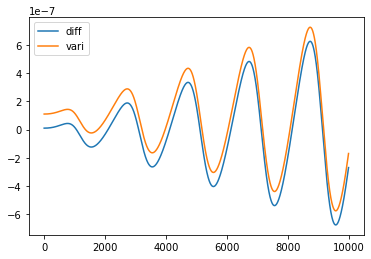

In [14]:
plt.plot(times-times[0], (states[:,1,:]-states[:,0,:])[:,0], label='diff')
plt.plot(times-times[0], var[:,0,0]*scale+1e-7, label='vari')
plt.legend()


We can see the difference between the two approaches more clearly by subtracting one from the other.  They are, indeed, very close.  The difference is due to the nonlinear terms that are not included in the variational equations.   The amplitude of difference is quadratic in time.  This is expect as the variational equations are valid to first order in the initial displacement.

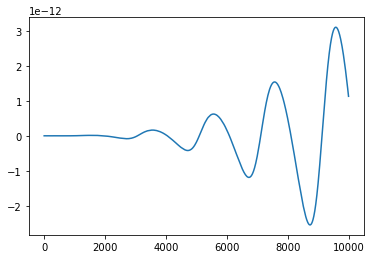

In [18]:
plt.plot(times-times[0], (states[:,1,:]-states[:,0,:]-var[:,0,:]*scale)[:,0], label='x')


The plot below shows the results for the x, y, and z components.

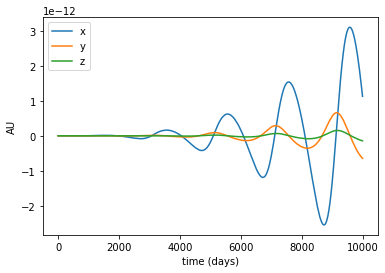

In [19]:
plt.plot(times-times[0], (states[:,1,:]-states[:,0,:]-var[:,0,:]*scale)[:,0], label='x')
plt.plot(times-times[0], (states[:,2,:]-states[:,0,:]-var[:,1,:]*scale)[:,1], label='y')
plt.plot(times-times[0], (states[:,3,:]-states[:,0,:]-var[:,2,:]*scale)[:,2], label='z')
#plt.ylim(-1e-13, 1e-13)
plt.xlabel("time (days)")
plt.ylabel("AU")
plt.legend()

### Chebyshev polynomials

Each combination of initial conditions and associated parameters represents a trajectory over some time span, finite or infinite.  For the purposes of fitting an orbit to observations, it is necessary to determine the position, and possibly velocity, at the light-time corrected times of the observations.  Thus, it is often necessary to be able to determine the dynamical state at arbitrary times along the trajectory.  Rather than repeated integrating to a set of observation times, it can be more efficient to integrate once to a series of reference times and then interpolate the results for other times.

Note that for each overall step taken by the integrator, a number of substeps are included in the output.  I have explored a couple of options for this.  One is output at each of the Gauss-Radau integration substeps.  Another is output at the conventional Chebyshev nodes, as well as the end points.  Both sets of output make interpolation relatively easy, but the latter appears to have better performance.  The goal is to ensure that the error associated with the interpolation is smaller than the error of the integration itself, which is machine precision for IAS15.



In [17]:
instates = np.array([row])
n_particles = 1

tstart, tstep, trange = 2458849.5, 20.0, 10000

epoch = tstart
tend = tstart + trange

timesp, statesp, varp, varp_ng, statusp = ephem_forces.production_integration_function_wrapper(tstart, tend, epoch, instates)


In [ ]:
statesp.shape

In [ ]:
import numpy.polynomial.chebyshev as ch



Let's set aside for now the idea of using the inverse vandermonde matrix and just concentrate on least squares fitting of chebyshev polynomials.

In [ ]:
pts = np.polynomial.chebyshev.chebpts1(7)
pts

In [ ]:
V = ch.chebvander(pts, 6 )

Vinv = np.linalg.inv(V)

In [ ]:
y = statesp[1:8,:,2]

In [ ]:
f0 = np.dot(Vinv, y)

In [ ]:
x = np.arange(-1, 1, 0.001)
x

In [ ]:
y0 = ch.chebval(x, f0)

In [ ]:
plt.plot(x, y0[0]-y[0])
#plt.ylim(-1e-15, 1e-15)

In [ ]:
y0, y

* integrate the trajectory over a time span. DONE
* get the observatory positions for a series of observations (these should be barycentric J2000 equatorial).
* fit the segments and save the results. DONE
* evaluate the trajectory at various times. DONE
* do light-time correction iteration from a specific observatory location at a specific time. DONE
* compare the model results to the observed results. DONE
* get the partial derivatives of the observables with respect to the parameters


In [ ]:
1e-7*1.5e8

In [ ]:
# include geocentric option
def get_observation_data(line, geocentric=False):
    
    fields = line.split()
    trackletID = fields[0].strip()
    obsCode = fields[4].strip()
    jd_tdb = float(fields[7])
        
    x_target, y_target, z_target = fields[8:11]
    r_target = np.array([float(x_target), float(y_target), float(z_target)])

    x_obs, y_obs, z_obs = fields[11:14]
    r_obs = np.array([float(x_obs), float(y_obs), float(z_obs)])
    if geocentric:
        r_E = np.array(MPC_library.getEarthPosition(jd_tdb))
        #r_E = np.array(ephem_forces.all_ephem(3, jd_tdb)[1:4])
        r_obs -= r_E
        print(jd_tdb, r_obs, obsCode)
    
    return jd_tdb, r_target, r_obs

In [ ]:
def get_basis(v):
    x, y, z = v
    r = np.sqrt(x*x + y*y)
    if r==0.0:
        A = np.array((-1, 0.0, 0.0))
    else:
        A = np.array((-y/r, x/r, 0.0))
    
    D = np.cross(v, A)
    
    return A, D
    
    

In [ ]:
v = np.array((0, 1, 0))
A, D = get_basis(v)

In [ ]:
A, D

In [ ]:
(36*8 + 36)/40

In [ ]:
def get_residuals(v1, v2):
    # This can be streamlined
    # The A and D matrices and be
    # saved for each data point
    x, y, z = v1
    #r = np.sqrt(x*x + y*y)
    delta = np.arcsin(z)
    alpha = np.arctan2(y, x)
    sina = np.sin(alpha)
    #sina = y/r
    cosa = np.cos(alpha)
    #cosa = x/r
    sind = np.sin(delta)
    #sind = z
    cosd = np.cos(delta)
    A = np.array((-sina, cosa, 0.0))
    D = np.array((-sind*cosa, -sind*sina, cosd))
    return (np.dot(v2, A), np.dot(v2, D))

In [ ]:
def save_trajectory(times, states):
    fits = []
    time_tags = []
    for i in range(0, len(times)-1, 8):
        data = np.reshape(states[i:i+9,:,0:3], (9, 3))
        x = times[i:i+9]-times[i+4]
        t0 = times[i+4]
        dt = x[-1]-x[0]
        f = ch.chebfit(2*x/dt, data, 7)
        fits.append((t0, dt, f))
        time_tags.append(times[i])
    time_tags = np.array(time_tags)
    return time_tags, fits

In [ ]:
# DE441
# (3666) Holman
#2458849.500000000 = A.D. 2020-Jan-01 00:00:00.0000 TDB [del_T=     69.183900 s]
# X = 3.338875349745594E+00 Y =-9.176518281675284E-01 Z =-5.038590682977396E-01
# VX= 2.805663319000732E-03 VY= 7.550408687780768E-03 VZ= 2.980028206579994E-03
row = [3.338875349745594E+00, -9.176518281675284E-01, -5.038590682977396E-01, 2.805663319000732E-03, 7.550408687780768E-03, 2.980028206579994E-03]


In [ ]:
tstart = 2458895.017041

       
#       2458895.017041000 = A.D. 2020-Feb-15 12:24:32.3424 TDB [del_T=     69.185127 s]
# X =-8.249088716487324E-01 Y = 5.128233312454121E-01 Z = 2.229322025922279E-01
# VX=-1.055227553661174E-02 VY=-1.358415461735038E-02 VZ=-5.295679016887025E-03
row = [-8.249088716487324E-01, 5.128233312454121E-01, 2.229322025922279E-01,
        -1.055227553661174E-02, -1.358415461735038E-02, -5.295679016887025E-03]

#2458894.500000000 = A.D. 2020-Feb-15 00:00:00.0000 TDB [del_T=     69.185116 s]
# X =-8.193874027610940E-01 Y = 5.198340919082048E-01 Z = 2.256562195597833E-01
# VX=-1.081684176011098E-02 VY=-1.353532640193796E-02 VZ=-5.241845834560792E-03

#2458894.500000000 = A.D. 2020-Feb-15 00:00:00.0000 TDB [del_T=     69.185116 s]
row = [-8.193874027610940E-01, 5.198340919082048E-01, 2.256562195597833E-01,
       -1.081684176011098E-02, -1.353532640193796E-02, -5.241845834560792E-03]

#2458897.500000000 = A.D. 2020-Feb-18 00:00:00.0000 TDB [del_T=     69.185180 s]
# X =-8.499386338554212E-01 Y = 4.787625651895777E-01 Z = 2.094777670024411E-01
# VX=-9.661210198068209E-03 VY=-1.385885178755969E-02 VZ=-5.532765642013616E-03
row = [-8.499386338554212E-01, 4.787625651895777E-01, 2.094777670024411E-01, 
    -9.661210198068209E-03, -1.385885178755969E-02, -5.532765642013616E-03]

#2458897.500000000 = A.D. 2020-Feb-18 00:00:00.0000 TDB [del_T=     69.185180 s]
# X =-3.118500479970055E-03 Y =-1.512873873465409E-03 Z = 1.239844826099388E-03
# VX=-3.789003661569063E-04 VY=-3.369885641555601E-04 VZ= 3.279972338540866E-04
row = [-3.118500479970055E-03, -1.512873873465409E-03, 1.239844826099388E-03, 
     -3.789003661569063E-04, -3.369885641555601E-04, 3.279972338540866E-04]

In [ ]:
instates = np.array([row])

n_particles = 1

tstart, tstep, trange = 2458849.5, 2.0, 2000
tstart, tstep, tend = 2458894.500000000, 2, 2458932.50

epoch = 2458897.500000000
#tend = tstart + trange

timesp, statesp, varp, varp_ng, statusp = ephem_forces.production_integration_function_wrapper(tstart, tend, epoch, instates, tstep=2.0, geocentric=1)#, epsilon=1e-8, tstep=20)


In [ ]:
len(timesp), len(statesp)

In [ ]:
timesp[-1], statesp[-1], statesp[0], timesp[0]

In [ ]:
#2458894.500000000 = A.D. 2020-Feb-15 00:00:00.0000 TDB [del_T=     69.185116 s]
K20C03D = np.array([-1.562333877039780E-03, -3.277988442969260E-04, 1.300908692605723E-04,
     -7.738749028274221E-04, -4.723132211708606E-04, 4.202738544505411E-04])

In [ ]:
 K20C03D = np.array([-8.855745866541963E-03, -6.174222186235641E-03, 7.065718386911509E-03,
 -1.282144988613095E-04, -1.338814161041129E-05, 6.548842150422916E-05])

In [ ]:
(K20C03D - statesp[-1])*1.5e8

In [ ]:
np.array(row).reshape(1, 6)

In [ ]:
6400*2*3.14/(24*60*60)

In [ ]:
tend

In [ ]:
obs = []
with open('3666_eq_bary.mpc') as file:
        line=file.readline()
        for line in file:
            jd_tdb, r_target, r_obs = get_observation_data(line)
            obs.append((jd_tdb, r_target, r_obs))

In [ ]:
2458895.017041000 = A.D. 2020-Feb-15 12:24:32.3424 TDB [del_T=     69.185127 s]
 X =-8.229843715810257E-01 Y = 5.133866216380784E-01 Z = 2.225894275786583E-01
 VX=-9.913923474824957E-03 VY=-1.314467346840790E-02 VZ=-5.697451462034082E-03

In [ ]:
(-8.229843715810257E-01 - -0.82298367)*1.5e8

In [ ]:
2458895.017040800 = A.D. 2020-Feb-15 12:24:32.3251 TDB [del_T=     69.185129 s]
 X = 2.764507164403535E-05 Y = 2.305643106867868E-05 Z =-2.280392275599578E-05
 VX=-1.452631451039335E-04 VY= 1.744508044393150E-04 VZ= 2.807803667368201E-07

In [ ]:
2458895.017041000 = A.D. 2020-Feb-15 12:24:32.3424 TDB [del_T=     69.185129 s]
 X = 2.764504255720905E-05 Y = 2.305646599986323E-05 Z =-2.280392269977366E-05
 VX=-1.452633651835234E-04 VY= 1.744506211807041E-04 VZ= 2.807807889159410E-07

In [ ]:
(2.764507164403535E-05 - 2.76444902e-05)*1.5e8, (2.305646599986323E-05-2.30537690e-05)*1.5e8, (-2.280392269977366E-05- -2.28050798e-05)*1.5e8

In [ ]:
(0.4*1.4/384400 )*206265

In [ ]:

2458895.496318000 = A.D. 2020-Feb-15 23:54:41.8752 TDB [del_T=     69.185137 s]
 X = 2.766814748701722E-05 Y =-1.157852792138350E-05 Z =-3.020367669904454E-05
 VX= 7.295045605972016E-05 VY= 1.746859269841296E-04 VZ=-1.391190084195478E-07    

In [ ]:
(-2.76658342e-05 - -2.766814748701722E-05)*1.5e8

In [ ]:
obs = []
with open('K20C03D_eq_bary.mpc') as file:
        line=file.readline()
        for line in file:
            jd_tdb, r_target, r_obs = get_observation_data(line, geocentric=True)
            obs.append((jd_tdb, r_target, r_obs))

In [ ]:
obs

In [ ]:
def find_segment(time_tags, t, tmax):
    if t < time_tags[0] or t > tmax:
        return -1
    elif t==time_tags[0]:
        return 0
    else:
        idx = np.searchsorted(time_tags, t)
        return idx-1



def trajectory(fits, time_tags, t, tmax):
    idx = find_segment(time_tags, t, tmax)
    t0, dt, c = fits[idx]
    x = 2*(t - t0)/dt
    model = ch.chebval(x, c)
    return model

au_km = 149597870.700 # This is now a definition 
speed_of_light = 2.99792458e5 * 86400./au_km


In [ ]:
# Need to include a geocentric option
def generate_observation(fits, time_tags, r_obs, t_obs, niter=5):
    lt = 0.0
    # probably don't need to look up the segment every time
    # probably don't need very high order chebyshev polynomials
    # probably already have a guess at lt from previous iterations.
    for i in range(niter):
        t = t_obs - lt
        pos = trajectory(fits, time_tags, t, timesp[-1])
        rho = pos-r_obs
        delta = np.sqrt(rho[0]*rho[0] + rho[1]*rho[1] + rho[2]*rho[2])
        #delta = np.linalg.norm(rho)
        rho = rho/delta
        lt = delta/speed_of_light
    return rho, lt


In [ ]:
def residuals(instates, obs, tstart, tend, geocentric=True):
    instates = instates.reshape(1, 6)
    timesp, statesp, varp, varp_ng, statusp = ephem_forces.production_integration_function_wrapper(tstart, tend, epoch, instates, tstep=2.0, geocentric=geocentric)
    time_tags, fits = save_trajectory(timesp, statesp)
    resid = []
    # don't need to repeatedly open this file to read and format the data
    for jd_tdb, r_target, r_obs in obs:
        model, lt = generate_observation(fits, time_tags, r_obs, jd_tdb)
        dx, dy = get_residuals(r_target, model)
        resid.append(dx)
        resid.append(dy)
        print("%.6lf %.5lf %7.3lf %7.3lf" % (jd_tdb, lt, dx*206265, dy*206265))
    return resid


In [ ]:

from scipy.optimize import least_squares

In [ ]:
%%prun
results = least_squares(residuals, np.array(row), args=(obs, tstart, tend), xtol=1e-12)

In [ ]:
results.x, row

In [ ]:
(results.x - instates[0])*1.5e8

In [ ]:
%%time
res0 = np.array(residuals(np.array(row).reshape(1, 6), obs, tstart, tend, geocentric=True))*206265
res1 = np.array(residuals(results.x, obs, tstart, tend))*206265

In [ ]:
res0.mean(), res0.std(), res1.mean(), res1.std()

In [ ]:
row, 

In [ ]:
instates_res = np.array([results.x.tolist()])

n_particles = 1

tstart, tstep, tend = 2458694.500000000, 2, 2459232.50

epoch = 2458897.500000000

timesp, statesp, varp, varp_ng, statusp = ephem_forces.production_integration_function_wrapper(tstart, tend, epoch, instates_res, tstep=2.0, geocentric=1)#, epsilon=1e-8, tstep=20)

tstart, tstep, tend = 2458894.500000000, 2, 2458932.50
timesf, statesf, varf, varf_ng, statusf = ephem_forces.production_integration_function_wrapper(tstart, tend, epoch, instates_res, tstep=2.0, geocentric=1)#, epsilon=1e-8, tstep=20)


In [ ]:
fig, ax = plt.subplots(figsize=(6.5,5))
#plt.figure(figsize=(5, 5))
ax.plot(statesp[:,:,0], statesp[:,:,1])
ax.plot(statesf[:,:,0], statesf[:,:,1])
ax.set_xlim(-0.030, 0.005)
ax.set_ylim(-0.020, 0.010)
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
plt.savefig('2020_CD3.png')

plt.tight_layout()
plt.show()

In [ ]:
def first(x):
    return x[0]

def second(x):
    return x[1]

In [ ]:
3400*1.0625/3

In [ ]:
0.5*384400/1.5e8

In [ ]:
ts = np.array(list(map(first, obs)))

In [ ]:
fig, ax = plt.subplots(figsize=(6.5,5))


ax.scatter(ts-ts[0], res1[0::2], s=4)
ax.scatter(ts-ts[0], res1[1::2], s=4)
ax.set_xlabel('days')
ax.set_ylabel('residual (arcsec)')
plt.savefig('residuals.png')
plt.tight_layout()
plt.show()


In [ ]:
results.x

In [ ]:
row

In [ ]:
results.x

In [ ]:
tstart, obs[0], tend, obs[-1]

In [ ]:
results.x

In [ ]:
_= plt.hist(res0, bins=30)
_= plt.hist(res1, bins=30)
plt.yscale('log')

In [ ]:
results.x - np.array(row)

In [ ]:
results

In [ ]:

instates = np.array([row])
timesp, statesp, varp, varp_ng, statusp = ephem_forces.production_integration_function_wrapper(tstart, tend, epoch, instates)

time_tags, fits = save_trajectory(timesp, statesp)

In [ ]:
%%time
diffs = []
for i, t in enumerate(timesp):
    diffs.append(statesp[i][0][0:3]-trajectory(fits, time_tags, t, timesp[-1]))

diffs = np.array(diffs)

In [ ]:
timesp[-1]

In [ ]:
x,y,z = trajectory(fits, time_tags, 2467000.5, timesp[-1])

In [ ]:
 test = np.array([3.513219995999942E+00, -6.229832838087752E-02, -1.608033362738477E-01])

In [ ]:
(test - trajectory(fits, time_tags, 2467000.5, timesp[-1]))*1.5e11

The interpolation errors look to be substantially less than 1 m, which is certainly good.  But I'm not quite sure why it's so large.

In [ ]:
plt.plot(timesp-timesp[0], diffs[:,0]*1.5e11)

A next step will be to iteratively generate a light-time corrected RA/Dec observation from a particular observatory at a particular observing time.

F51 at JD 2467000.5 TDB.

In [ ]:
F51 = np.array([-8.162323545253964E-01, -5.297985179472369E-01, -2.298084817347363E-01])
F51 = np.array([-9.116190007936418E-01, 3.719152151402167E-01, 1.614743792421127E-01])


In [ ]:
t_obs = 2460000.5


In [ ]:
generate_observation(fits, time_tags, F51, t_obs)

In [ ]:
x, y, z

In [ ]:
x, y, z = (pos-F51)/delta

In [ ]:
((180./np.pi*np.arctan2(y, x)) + 360 - 204.262489518)*3600

In [ ]:
x, y, z

In [ ]:

(180./np.pi*np.arcsin(z) - -6.836971568)*3600

In [ ]:
00 24 38.49 +00 54 24.4
13 37 03.00 -06 50 13.1
204.262489518  -6.836971568


In [ ]:
delta_t = 69.185544/86400.
delta_t = 69.185284/86400.
t_utc = t_obs-delta_t
t_utc

In [ ]:
i=0
sat_dict = defaultdict(list)
with open('3le_new.txt') as f:
    lines = f.readlines()
    first = lines[0::3]
    second = lines[1::3]
    third = lines[2::3]
    names = list(map(lambda x: x[2:].rstrip(), first))
    mm = list(map(lambda x: float(x[53:64]), third))

In [ ]:
_=plt.hist(mm, bins=21, cumulative=False, range=(0,1.05))
plt.yscale('log', nonposy='clip')
plt.xlabel('rev/day')
plt.ylabel('N')
plt.savefig('rev_hist_v4.png')

In [ ]:
sat_dict = {k:v for k,v in zip(names, mm)}

In [ ]:
def secnd(x):
    return x[1]

In [ ]:
with open('names_mm.txt', 'w') as f:
    for k,v in sorted(zip(names, mm), key=secnd):
        f.write('%15f %s\n'% (v, k))

### Challenging Examples

Now let's try some more challenging cases.  First Apophis, an NEO that makes repeated close approaches to Earth.  It will make an approach on 2021 Mar 06 1:06 UT.  This approach will not be particularly close.  However, the 2029 Apr 13 approach will be extremely close.

The initial conditions below are for 2020 Aug 01, before the first approach.  We will integrate through the first approach and to just before the closer second approach.

In [ ]:
importlib.reload(ephem_forces)

In [ ]:
# DE441
#2459062.500000000 = A.D. 2020-Aug-01 00:00:00.0000 TDB [del_T=     69.183254 s]
# X =-5.147481787179418E-03 Y =-7.554300268214853E-01 Z =-2.803431979691921E-01
# VX= 1.994372371206607E-02 VY= 2.695051098855493E-03 VZ= 1.506829667479476E-03
row = [-5.147481787179418E-03, -7.554300268214853E-01, -2.803431979691921E-01,
        1.994372371206607E-02, 2.695051098855493E-03, 1.506829667479476E-03]

# DE431
#row = [-5.145897476309183E-03, -7.554295792725090E-01, -2.803430954241811E-01, 1.994372392258838E-02, 2.695069501106252E-03, 1.506836811826654E-03]
    
tstart, tstep, trange = 2459062.5, 1.0, 3150
tend = tstart + trange
geocentric = 0
n_particles = 1
scale = 1e-8

instates = np.array(row)

times, states, var, var_ng, status = ephem_forces.integration_function(tstart, tend, tstep, geocentric, 
                                                               n_particles, instates, n_var, invar_part, invar)#, epsilon=1e-8)


In [ ]:
times[-1], states[-1][0]


In [ ]:
2462212.500000000 = A.D. 2029-Mar-17 00:00:00.0000 TDB [del_T=     69.185579 s]
 X =-1.065242948790426E+00 Y = 1.336576685926274E-02 Z =-2.189407072944644E-02
 VX= 1.615083976122256E-03 VY=-1.426641205899967E-02 VZ=-5.259456864467629E-03

In [ ]:
# No non-gravs
apophis_before = np.array([
-1.065242948790426E+00, 1.336576685926274E-02, -2.189407072944644E-02,
 1.615083976122256E-03, -1.426641205899967E-02, -5.259456864467629E-03])


# Including non-gravs
# dt_min = 1e-3
# epsilon = 1e-8
#apophis_before = np.array([
#    -1.061749621090919E+00, -1.342851936299780E-02, -3.176051171408323E-02,
#     2.104893542927364E-03, -1.426673477234808E-02, -5.247194855985309E-03])




In [ ]:
(states[-1][0]-apophis_before)*1.5e8

The largest discrepancy is ~42 km just before the 2029 close approach.

Now I will include the non-gravitational terms, using the A2 value provided by JPL Horizons (A1 and A3 = 0.0).

At the moment, the non-grav values are hard-coded.  The code needs to be recompiled and the library reloaded.

In [ ]:
importlib.reload(ephem_forces)

In [ ]:
# DE441
#2459062.500000000 = A.D. 2020-Aug-01 00:00:00.0000 TDB [del_T=     69.183254 s]
# X =-5.147481787179418E-03 Y =-7.554300268214853E-01 Z =-2.803431979691921E-01
# VX= 1.994372371206607E-02 VY= 2.695051098855493E-03 VZ= 1.506829667479476E-03
row = [-5.147481787179418E-03, -7.554300268214853E-01, -2.803431979691921E-01,
        1.994372371206607E-02, 2.695051098855493E-03, 1.506829667479476E-03]

# DE431
#row = [-5.145897476309183E-03, -7.554295792725090E-01, -2.803430954241811E-01, 1.994372392258838E-02, 2.695069501106252E-03, 1.506836811826654E-03]
    
tstart, tstep, trange = 2459062.5, 1.0, 3150
tend = tstart + trange
geocentric = 0
n_particles = 1
scale = 1e-8

instates = np.array(row)

times, states, var, var_ng, status = ephem_forces.integration_function(tstart, tend, tstep, geocentric, n_particles, instates, n_var, invar_part, invar)#, epsilon=1e-8)



In [ ]:
times[-1]

In [ ]:
apophis_after = np.array([
-6.343441804789555E-01, -6.456269834869176E-01, -2.636333964165063E-01,
 1.546139923046551E-02, -1.029411916646655E-02, -3.777044399870865E-03])

In [ ]:
states[-1][0], (states[-1][0]-apophis_before)*1.5e8

In [ ]:
states[-1][0], (states[-1][0]-apophis_after)*1.5e8

Now the largest discrepancy is ~1 km.  How carefully the very close approaches are handled matters, as expected.

Let's try geocentric integrations.

In [ ]:
row = [6.634500992578179E-02, 2.122458699845356E-03, -3.507415858744104E-04,
     -1.060257698567525E-03, 6.078332955992950E-04, 2.240712392485767E-04]

In [ ]:
tstart, tstep, trange = 2459062.5, -1.0, -400
geocentric = 1
n_particles = 1
scale = 1e-8

instates = np.array(row)
timesb, statesb, n_out, n_particles = ephem_forces.integration_function(tstart, tstep, trange, geocentric, n_particles, instates)  


In [ ]:
statesb

In [ ]:
plt.plot(statesb[:,0,0], statesb[:,0,1])

In [ ]:
del statesb

In [ ]:
tstart, tstep, trange = 2459062.5, 1.0, 400
geocentric = 1
n_particles = 1
scale = 1e-8
instates = np.array(row)

timesf, statesf, n_out, n_particles = ephem_forces.integration_function(tstart, tstep, trange, geocentric, n_particles, instates)

In [ ]:
statesf

In [ ]:
plt.plot(statesf[:,0,0], statesf[:,0,1])
plt.plot(statesb[:,0,0], statesb[:,0,1])

In [ ]:
tstart, tstep, trange = timesb[-1], 1.0, 400
instatesb = statesb[-1][0].copy()
timesf, statesf, n_out, n_particles = ephem_forces.integration_function(tstart, tstep, trange, geocentric, n_particles, instatesb)  

In [ ]:
plt.plot(statesb[:,0,0], statesb[:,0,1])

plt.plot(statesf[:,0,0], statesf[:,0,1])

In [ ]:
statesb

In [ ]:
len(states)

In [ ]:

2462263.697021989 = A.D. 2029-May-07 04:43:42.6999 TDB 
 X = 7.771821449378258E-02 Y = 1.444568330466675E-02 Z = 2.318152988506329E-02
 VX= 3.531021355764523E-03 VY= 8.992784904633009E-04 VZ= 1.064745760510192E-03



In [ ]:
apophis_geo_after=np.array([
    7.771821449378258E-02, 1.444568330466675E-02, 2.318152988506329E-02, 
    3.531021355764523E-03, 8.992784904633009E-04, 1.064745760510192E-03])


In [ ]:
(states[-1][0]-apophis_geo_after)*1.5e8

This is worse.  I wonder if this is due to the interpolated acceleration of the Earth.

In [ ]:
def plot_results(results):
    t, p0, p1, p2 = results
    d = np.linalg.norm(p0, axis=1)
    z = np.polyfit(t, d, deg=2)
    f = np.poly1d(z)
    plt.plot(t, d-f(t), label='x')
    #plt.plot(t, d, label='x')
    d = np.linalg.norm(p1, axis=1)
    z = np.polyfit(t, d, deg=2)
    f = np.poly1d(z)
    plt.plot(t, d-f(t), label='y')
    #plt.plot(t, d, label='y')
    d = np.linalg.norm(p2, axis=1)
    z = np.polyfit(t, d, deg=2)
    f = np.poly1d(z)
    plt.plot(t, d-f(t), label='z')
    #plt.plot(t, d, label='z')
    plt.legend()

In [ ]:
prec_x = np.array(sorted([(k, np.linalg.norm(p0[-1]), np.linalg.norm(p1[-1]), np.linalg.norm(p2[-1])) for k, (t, p0, p1, p2) in results_dict.items()]))



In [ ]:
plt.plot(prec_x[:,0], prec_x[:, 1])
plt.plot(prec_x[:,0], prec_x[:, 2])
plt.plot(prec_x[:,0], prec_x[:, 3])
plt.yscale('log')
plt.xscale ('log')

In [ ]:
plot_results(results_dict[1e-6])

In [ ]:
np.logspace(-8, -2, num=10)